# Perform Classification on the ADNI dataset using Bagging:

## Importing stuff:

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

## Read the Data:

In [2]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head()

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2


In [13]:
# Weird errors silencing when creating the new dataframe:
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::RuntimeWarning,ignore::ConvergenceWarning')

mca_data = np.load("./DATA/MCA_Transformed_Genetic_data_10_components.pkl.npy")
print("MCA data: ", mca_data.shape)

opnmf_coeffs = pd.read_csv("./DATA/loading_coefficients_30components.tsv", sep='\t')
print("opnmf_coeffs shape: ", opnmf_coeffs.shape)

o = list(opnmf_coeffs.columns)
opnmf_names = ["imaging_"+o[i] for i in range(o.index("component_1"), len(o))]

# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = genetic_columns
print("Before: ",lr_data.shape)
mca = lr_data.drop(labels = columns_to_drop, axis=1)

# Embed them into the new dataset:
component_labels = ["genetic_component_"+str(x+1) for x in range(mca_data.shape[1])] 
mca[component_labels] = mca_data
print("After: ",mca.shape)


mca = mca[mca['PTID'].isin(opnmf_coeffs['participant_id'])]
mca.reset_index(drop=True, inplace=True)
print(mca.shape)


opnmf = mca.drop(labels = MRI_columns, axis = 1)
opnmf[opnmf_names] = opnmf_coeffs.loc[:,"component_1":"component_30"]

data = opnmf.reset_index(drop=True)
print(data.shape)
print(list(data.columns))
data.head()

MCA data:  (1302, 10)
opnmf_coeffs shape:  (1294, 33)
Before:  (1302, 209)
After:  (1302, 165)
(1294, 165)
(1294, 50)
['PTID', 'MRID', 'Date', 'Age', 'Sex', 'DLICV_baseline', 'APOE4_Alleles', 'APOE_Genotype', 'Diagnosis_nearest_2.0', 'Diagnosis_nearest_2.0_cat', 'genetic_component_1', 'genetic_component_2', 'genetic_component_3', 'genetic_component_4', 'genetic_component_5', 'genetic_component_6', 'genetic_component_7', 'genetic_component_8', 'genetic_component_9', 'genetic_component_10', 'imaging_component_1', 'imaging_component_2', 'imaging_component_3', 'imaging_component_4', 'imaging_component_5', 'imaging_component_6', 'imaging_component_7', 'imaging_component_8', 'imaging_component_9', 'imaging_component_10', 'imaging_component_11', 'imaging_component_12', 'imaging_component_13', 'imaging_component_14', 'imaging_component_15', 'imaging_component_16', 'imaging_component_17', 'imaging_component_18', 'imaging_component_19', 'imaging_component_20', 'imaging_component_21', 'imaging_co

,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,...,839.09924,619.7323,681.45100,832.0467,659.40180,598.43787,737.67930,849.0394,653.38510,529.58984
1,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,...,765.77704,861.1545,674.06160,755.7838,719.56067,937.99410,694.54680,825.4079,766.40090,773.84576
2,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,...,1046.81020,843.5071,877.13410,885.0218,911.55505,906.45730,701.53510,894.4284,837.21240,713.27203
3,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,...,857.98660,813.3923,913.79160,875.5856,1001.27344,827.59820,686.68600,651.2841,764.98206,742.52910
4,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,...,600.88570,702.8355,673.74255,764.6585,650.25160,685.98645,587.51636,666.1610,624.62510,647.47455


## Defining helper functions:

In [14]:
def perform_classification(X_train, X_test, Y_train, Y_test, model, params):
    # Performing Grid Search and Cross Validation in order to find the best combination of parameters:
    clf = GridSearchCV(model, params, n_jobs=-1, cv=5)
    clf.fit(X_train,Y_train)
    # Finding the best classifier's prediction, and then computing the metrics. 
    pred =  clf.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred, normalize='true')
    bal_acc = balanced_accuracy_score(Y_test, pred)
    print("Best Parameters:",clf.best_params_)
    return acc, f1, bal_acc, np.around(cm, decimals=2), clf.best_params_

def barplot_scores(Accuracies, F1s, Bal_Accuracies, Names):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8), dpi=600)
    
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 
    
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    plt.bar(br3, [100*x for x in Bal_Accuracies], color ='g', width = barWidth, edgecolor ='grey', label ='Balanced Accuracy')
    
    plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
    plt.ylabel('Accuracy Score (%)', fontweight ='bold', fontsize = 15)
    
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names, rotation=45)
    plt.grid()
    plt.legend(prop={'size': 7})
    plt.show()
    return

def confusion_matrices(Confusion_Matrices, names, n_rows=2, n_cols=3):
    fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(22,22));
    sns.set(font_scale=1) # for label size
    
    # No DCCA:
    for i in range(len(names)):
        row, col = i // n_cols, i % n_cols
        ytick = False
        xtick = False

        if col == 0:
            ytick = ["CN", "AD", "MCI"]
        if row == n_rows - 1:
            xtick = ["CN", "AD", "MCI"]
            
        sns.heatmap(Confusion_Matrices[i], annot=True, annot_kws={"size": 16}, ax = axes[row][col], fmt='g',
                   xticklabels = xtick, yticklabels = ytick).set_title(names[i])
            
    plt.show()
    return

def undersample(df, ylabel='Diagnosis_nearest_2.0'):
    classes = df[ylabel].value_counts().to_dict() # specific to this dataset
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[ylabel] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

## Perform Classification using Bagging:

###  With base estimator being Decision Tree:

In [15]:
# Defining the Bagging model, as well as the model parameters for the Grid Search:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True,bootstrap_features=False, max_features=1.0, n_jobs=-1)
params = {
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'base_estimator__criterion': ["gini", "entropy"],    
    'base_estimator__max_depth': [1,2,5]
}

# The different trial names (for saving the best parameters if needed):
names = ['Both without DCCA']

# Saving the metrics and the Confusion Matrices, as well as the best parameter combinations:
Accuracies = []
F1s = []
Balanced_Accuracies = []
Confusion_Matrices = []
Best_parameter_combinations = []

##############################################################################  FAMD IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = data[component_labels + opnmf_names]
Y = data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model, params)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)


Trial_info = []
for i in range(len(names)):
    Trial_info.append([Accuracies[i],
                       Balanced_Accuracies[i],
                       Confusion_Matrices[i],
                       Best_parameter_combinations[i]])
print(Trial_info)

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################
Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 5, 'max_samples': 0.6, 'n_estimators': 15}
[[0.5096525096525096, 0.4463046202462679, array([[0.51, 0.01, 0.48],
       [0.04, 0.22, 0.74],
       [0.32, 0.08, 0.61]]), {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 5, 'max_samples': 0.6, 'n_estimators': 15}]]
Model with max Accuracy:  Both without DCCA  with an Accuracy score of  50.965
Model with max F1 Score:  Both without DCCA  with an F1 Score of  49.739
Model with max Balanced Accuracy Score:  Both without DCCA  with a Balanced Accuracy Score of  44.63


### Visualizing the results:

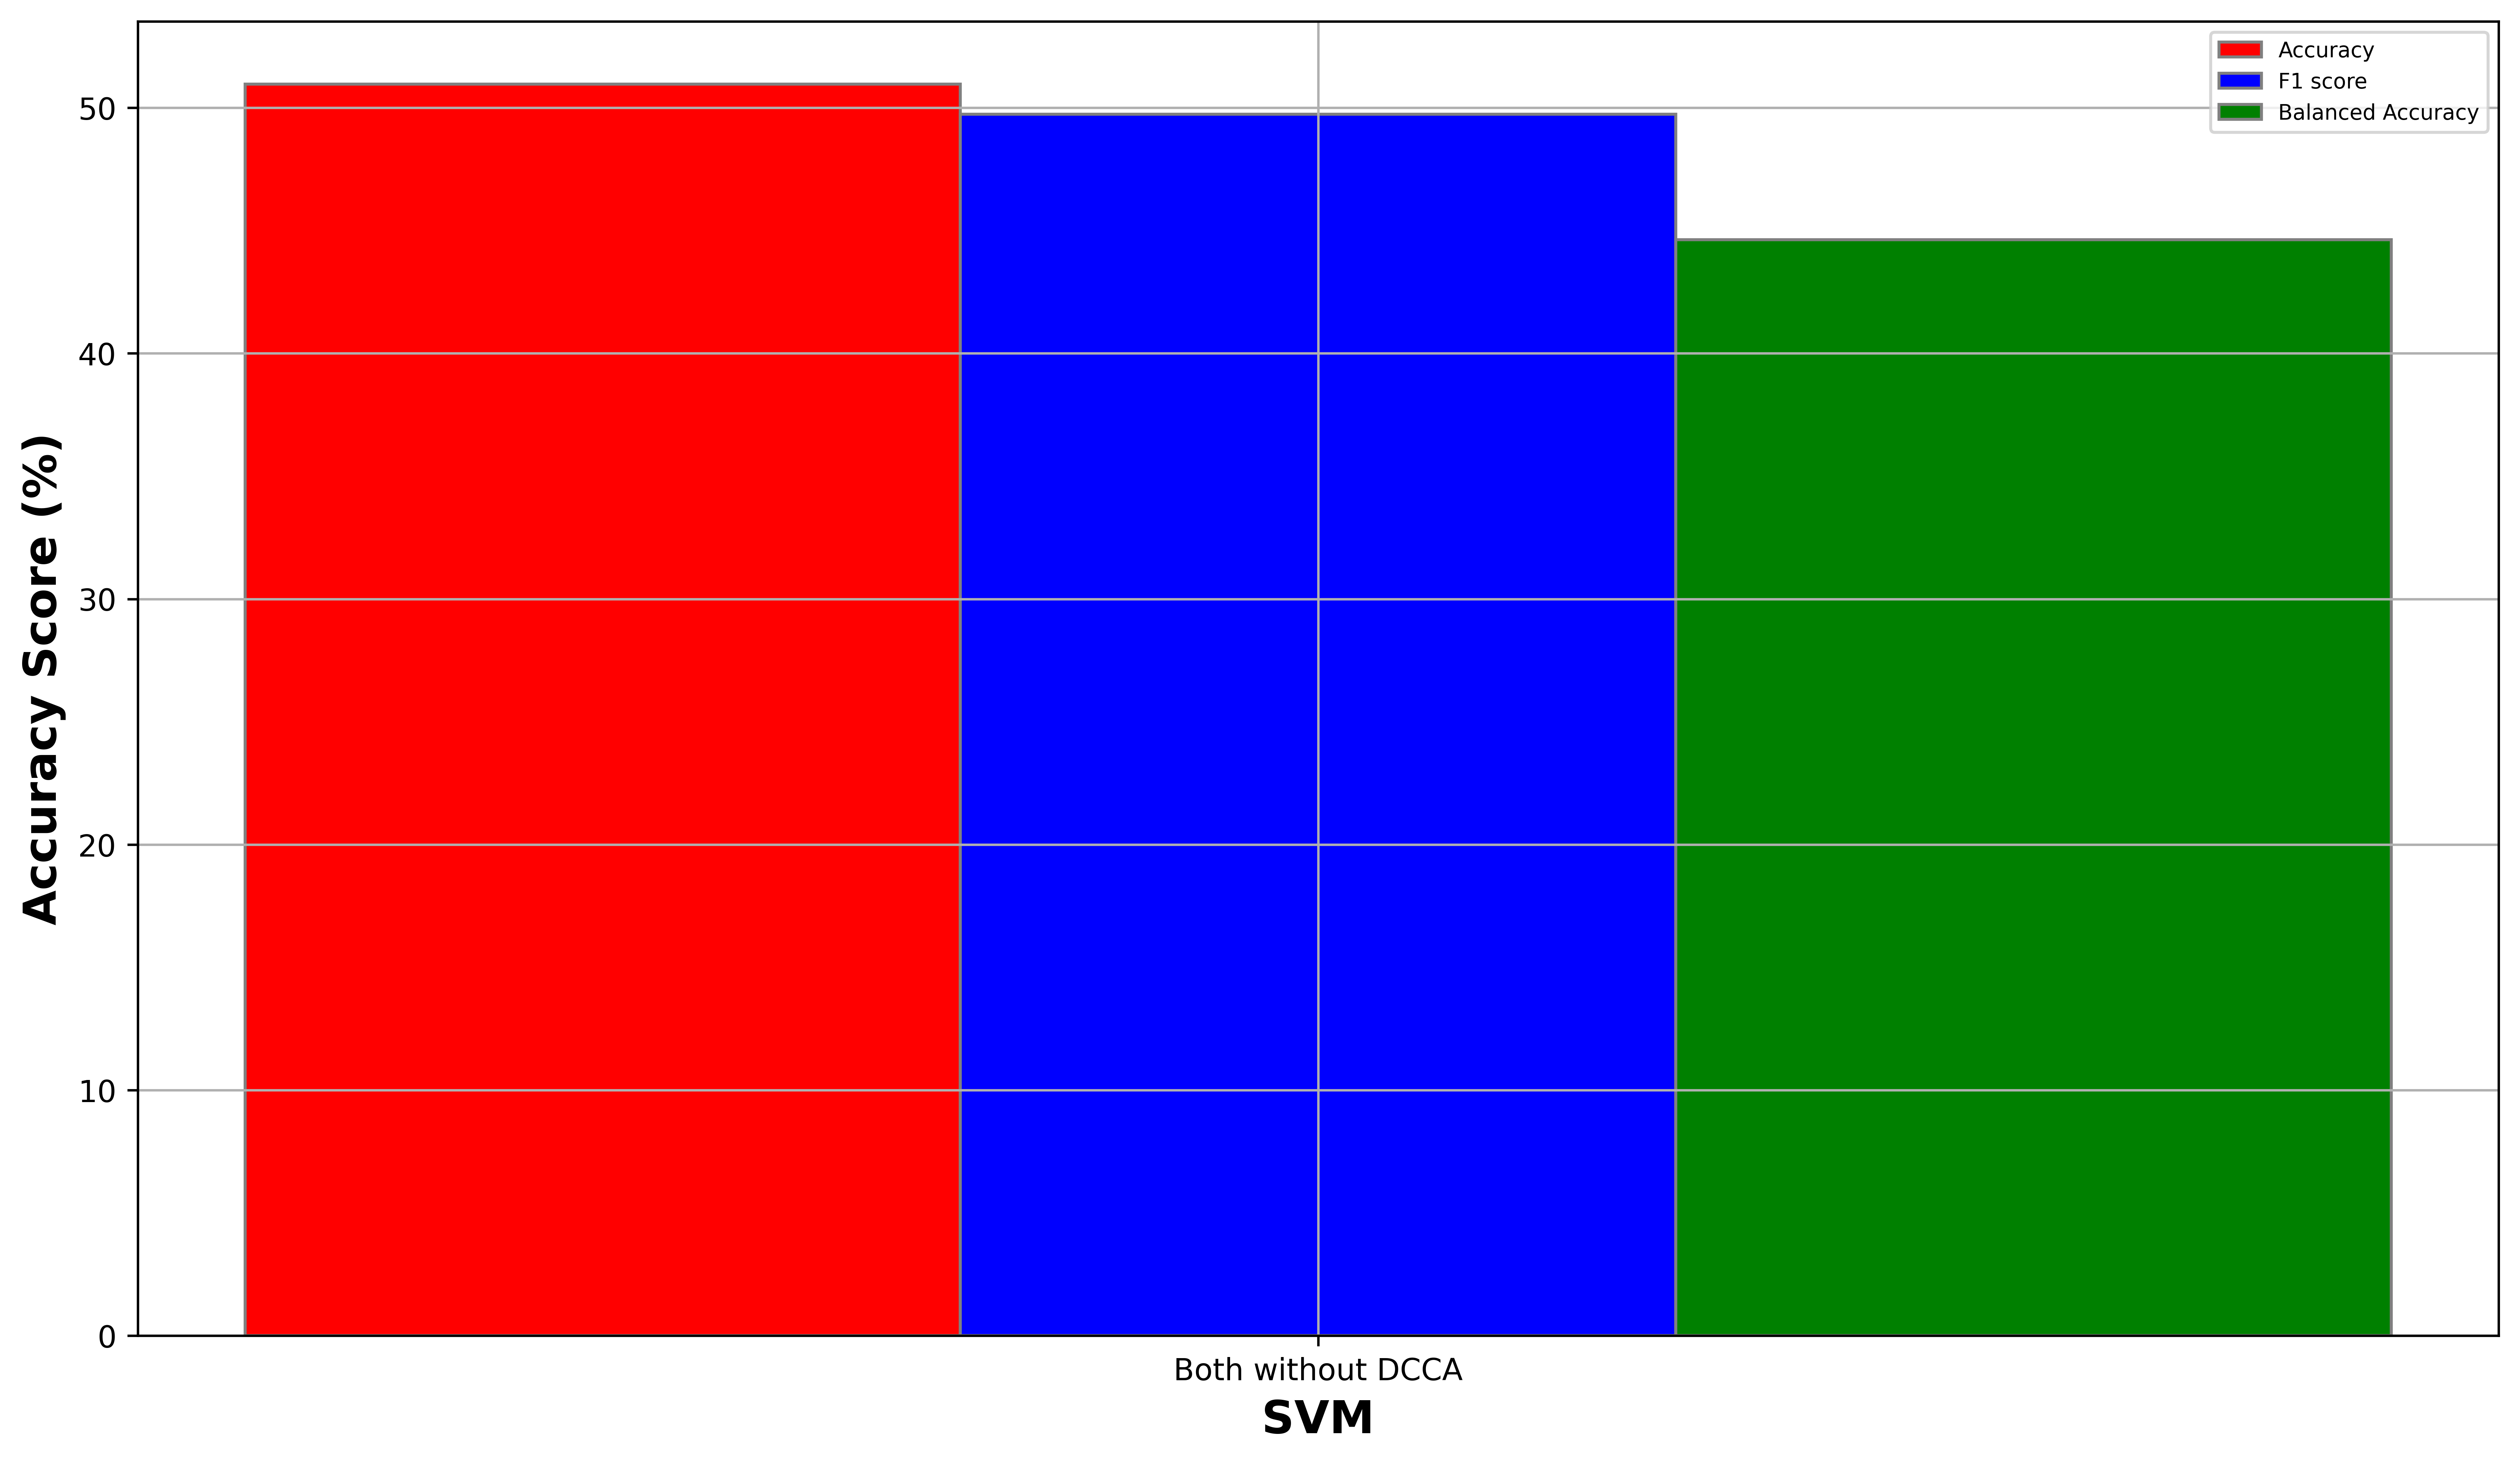

In [16]:
barplot_scores(Accuracies, F1s, Balanced_Accuracies, names)

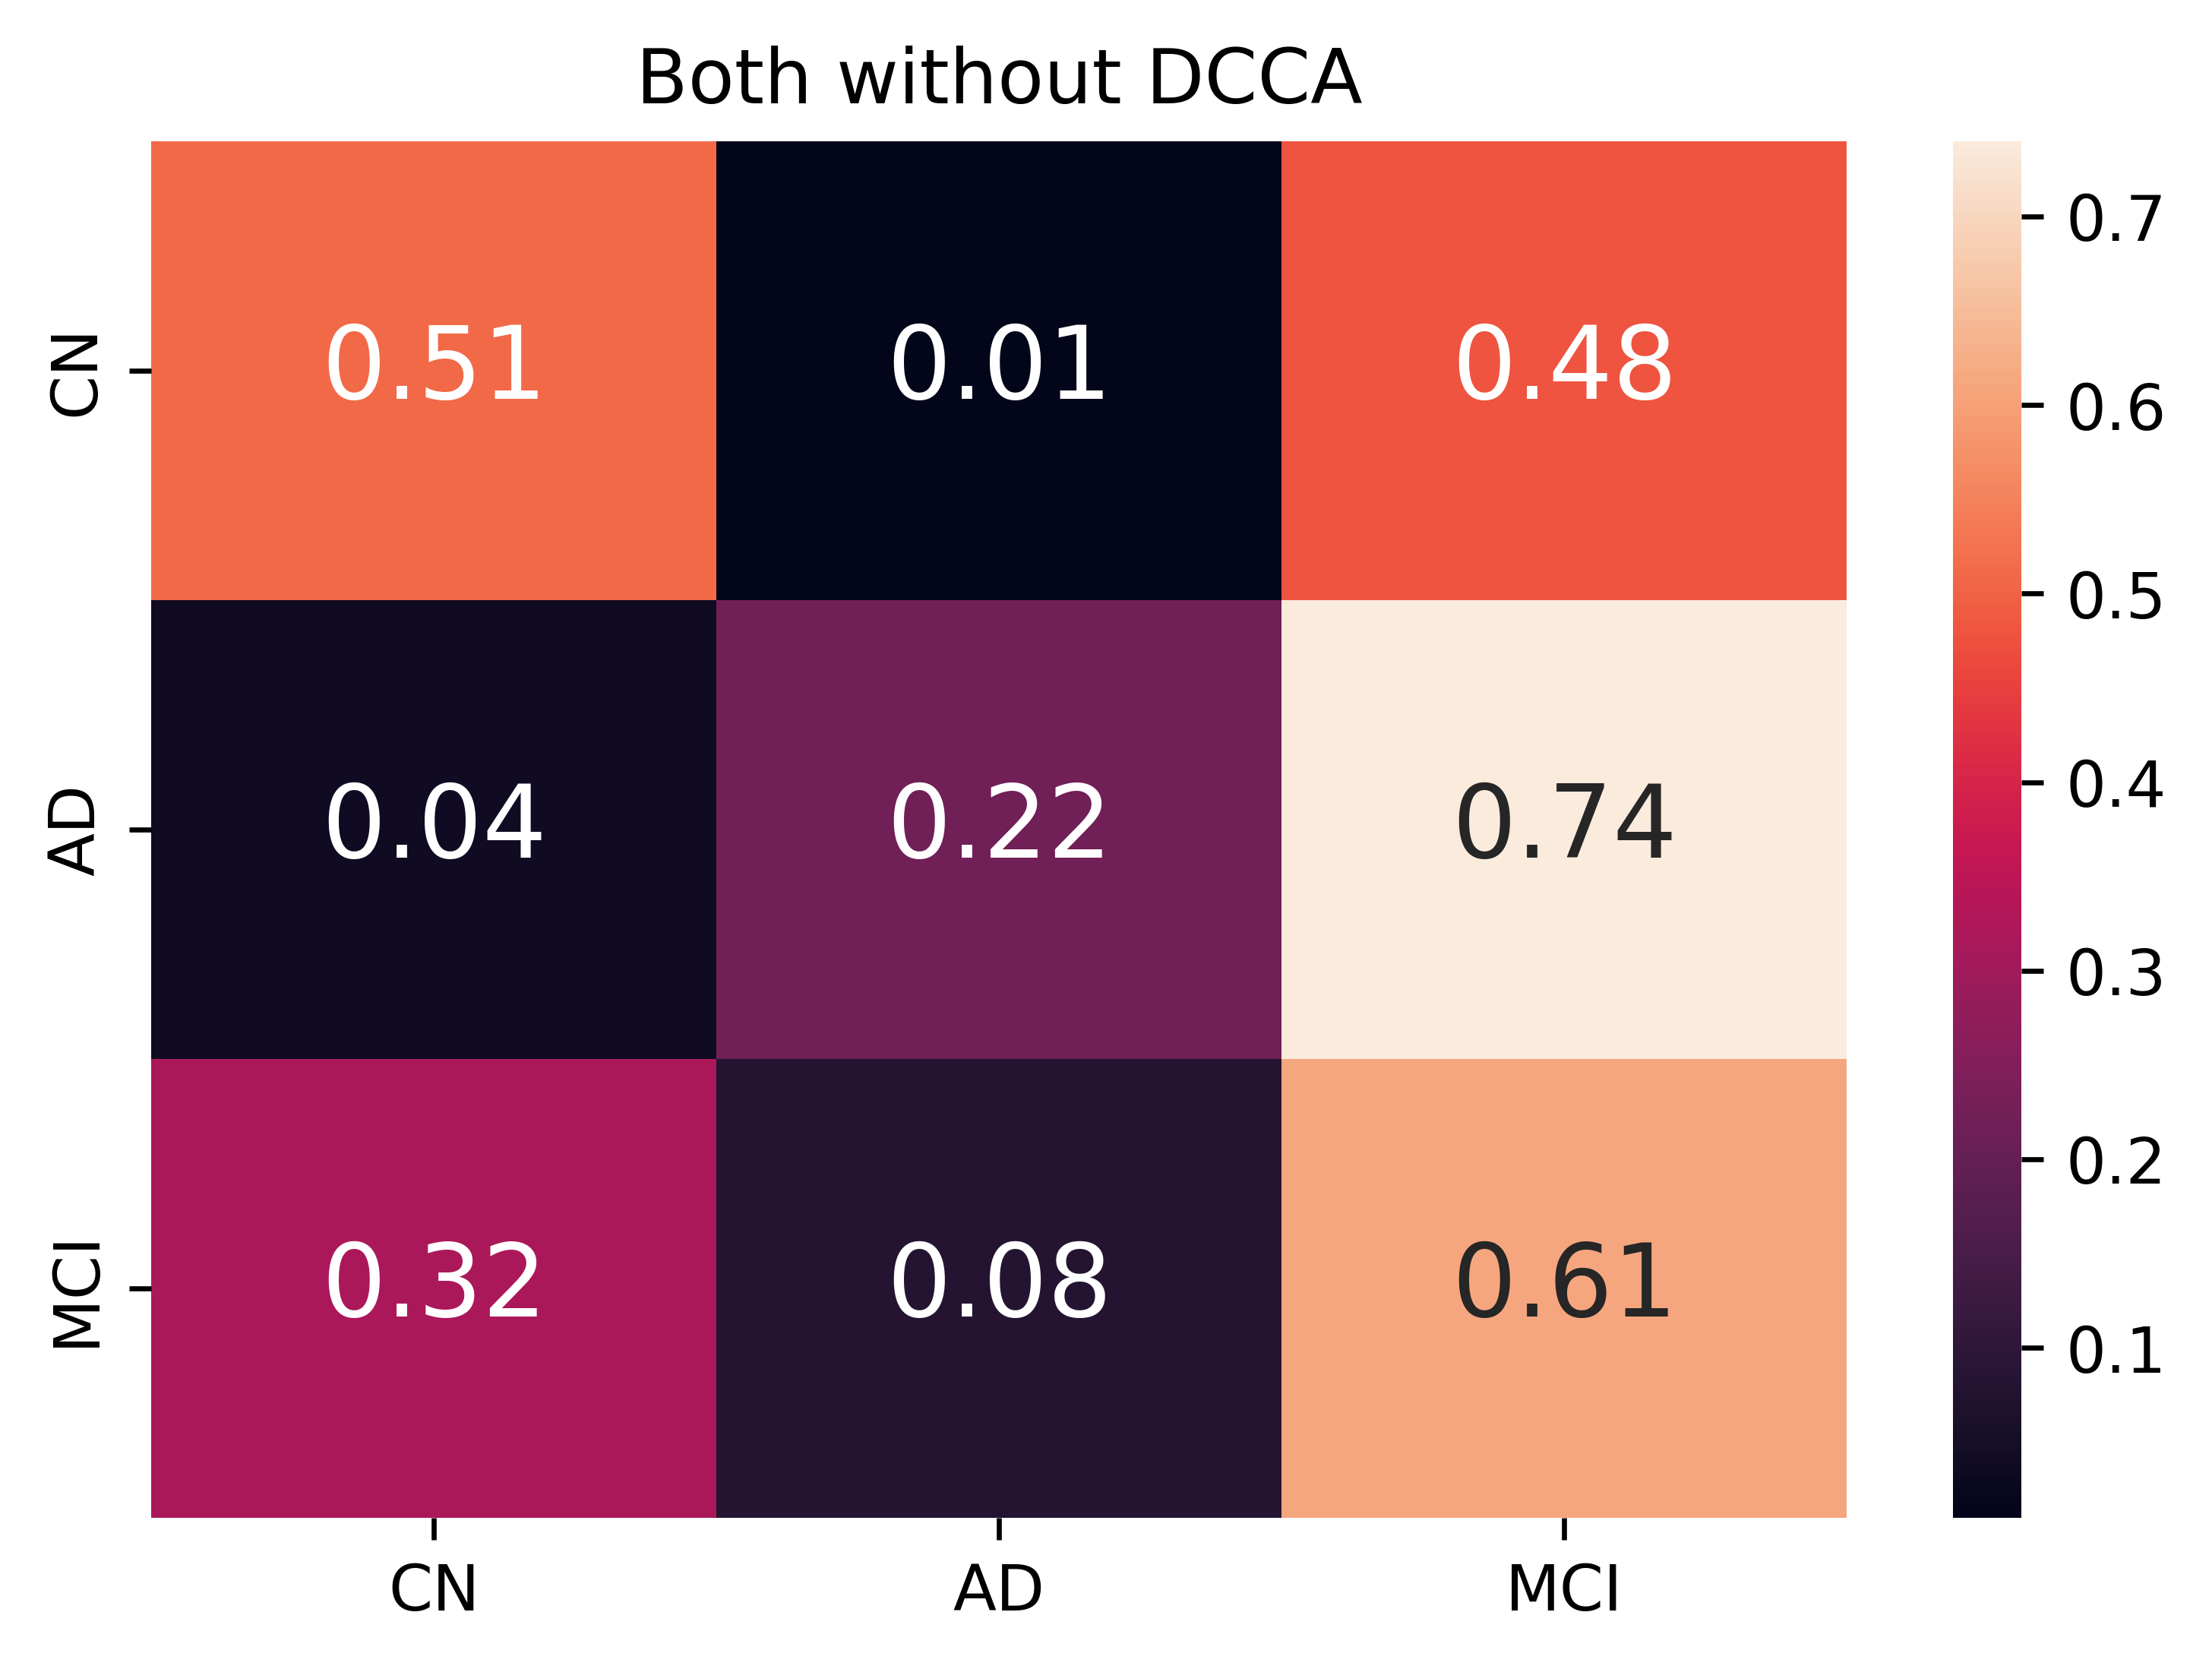

In [17]:
fig = plt.figure(dpi=600)
sns.heatmap(Confusion_Matrices[0], annot=True, annot_kws={"size": 16}, fmt='g',
                   xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title(names[0])
plt.show()

###  With base estimator being SVM:

In [18]:
# Defining the Bagging model, as well as the model parameters for the Grid Search:
model = BaggingClassifier(base_estimator=LinearSVC(), bootstrap=True,bootstrap_features=False, max_features=1.0, n_jobs=-1)
params = {
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'base_estimator__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

# The different trial names (for saving the best parameters if needed):
names = ['Both without DCCA']

# Saving the metrics and the Confusion Matrices, as well as the best parameter combinations:
Accuracies = []
F1s = []
Balanced_Accuracies = []
Confusion_Matrices = []
Best_parameter_combinations = []

##############################################################################  FAMD IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = data[component_labels + opnmf_names]
Y = data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model, params)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)


Trial_info = []
for i in range(len(names)):
    Trial_info.append([Accuracies[i],
                       Balanced_Accuracies[i],
                       Confusion_Matrices[i],
                       Best_parameter_combinations[i]])
print(Trial_info)

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################


/Users/georgeaidinis/opt/anaconda3/envs/Testing/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgeaidinis/opt/anaconda3/envs/Testing/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgeaidinis/opt/anaconda3/envs/Testing/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgeaidinis/opt/anaconda3/envs/Testing/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgeaidinis/opt/anaconda3/envs/Testing/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of

Best Parameters: {'base_estimator__C': 1e-05, 'max_samples': 1.0, 'n_estimators': 5}
[[0.4864864864864865, 0.4739280265882096, array([[0.51, 0.01, 0.48],
       [0.07, 0.41, 0.52],
       [0.44, 0.07, 0.5 ]]), {'base_estimator__C': 1e-05, 'max_samples': 1.0, 'n_estimators': 5}]]
Model with max Accuracy:  Both without DCCA  with an Accuracy score of  48.649
Model with max F1 Score:  Both without DCCA  with an F1 Score of  48.886
Model with max Balanced Accuracy Score:  Both without DCCA  with a Balanced Accuracy Score of  47.393


### Visualizing the results:

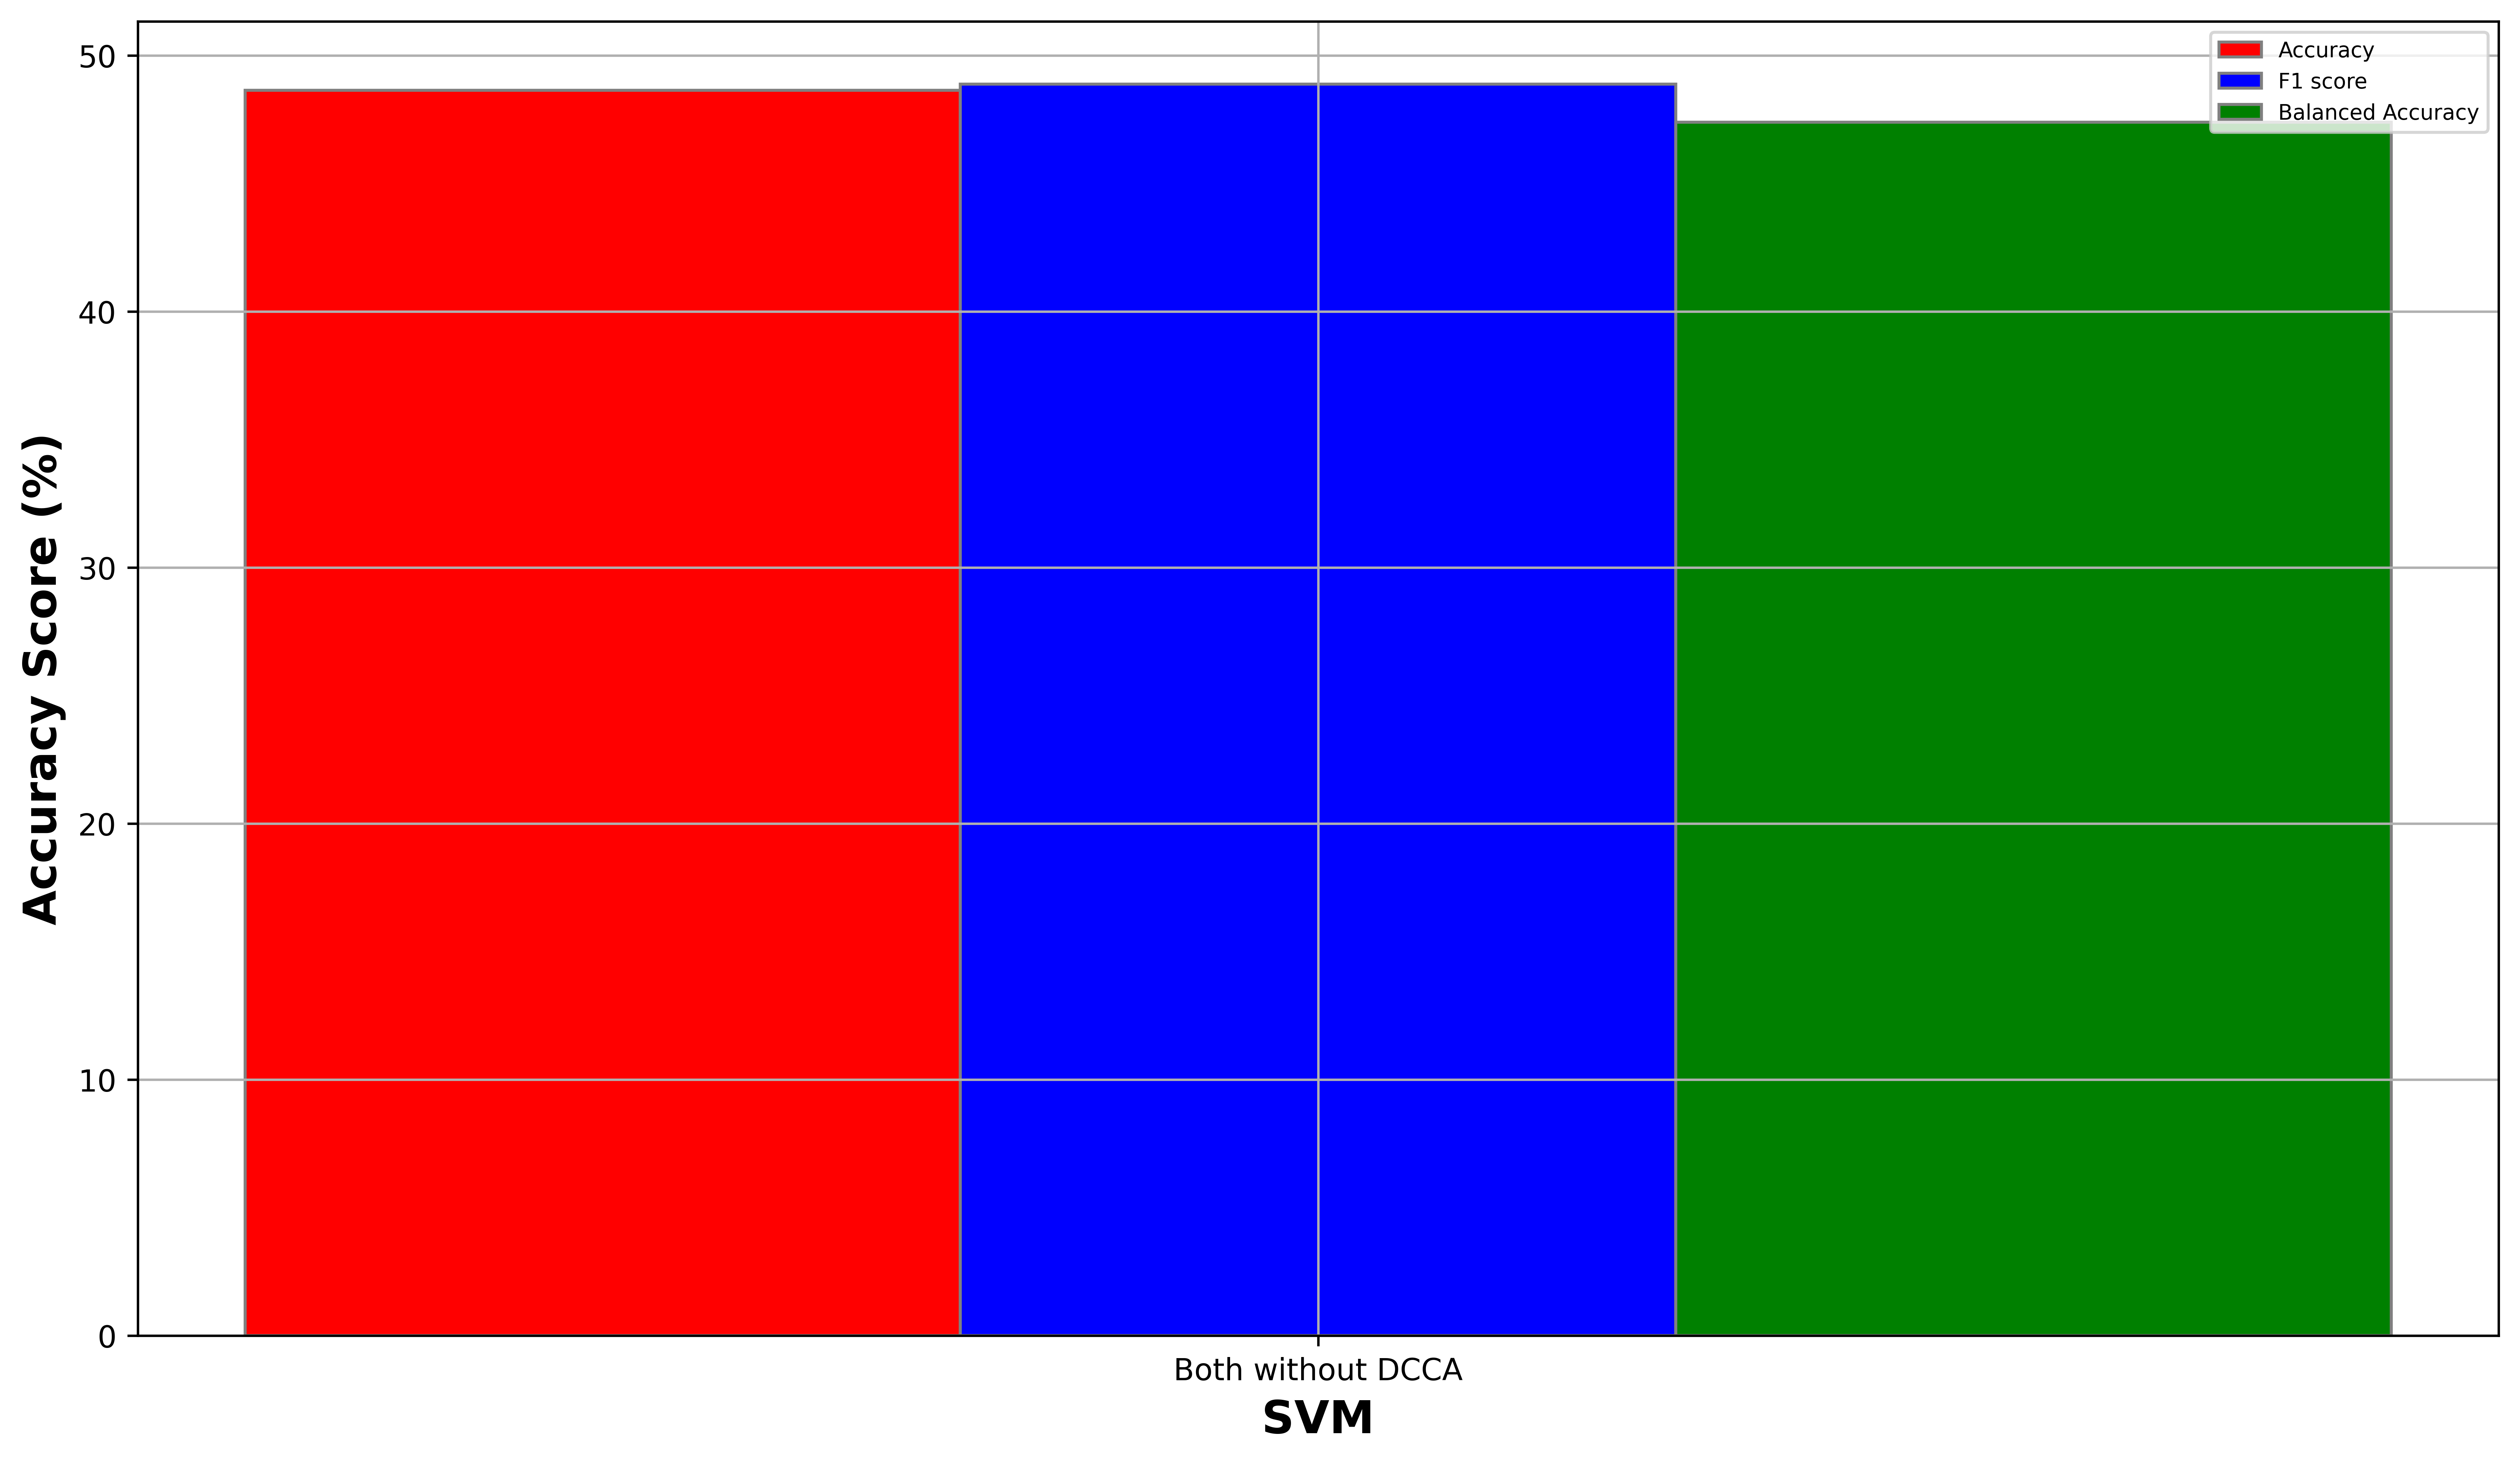

In [19]:
barplot_scores(Accuracies, F1s, Balanced_Accuracies, names)

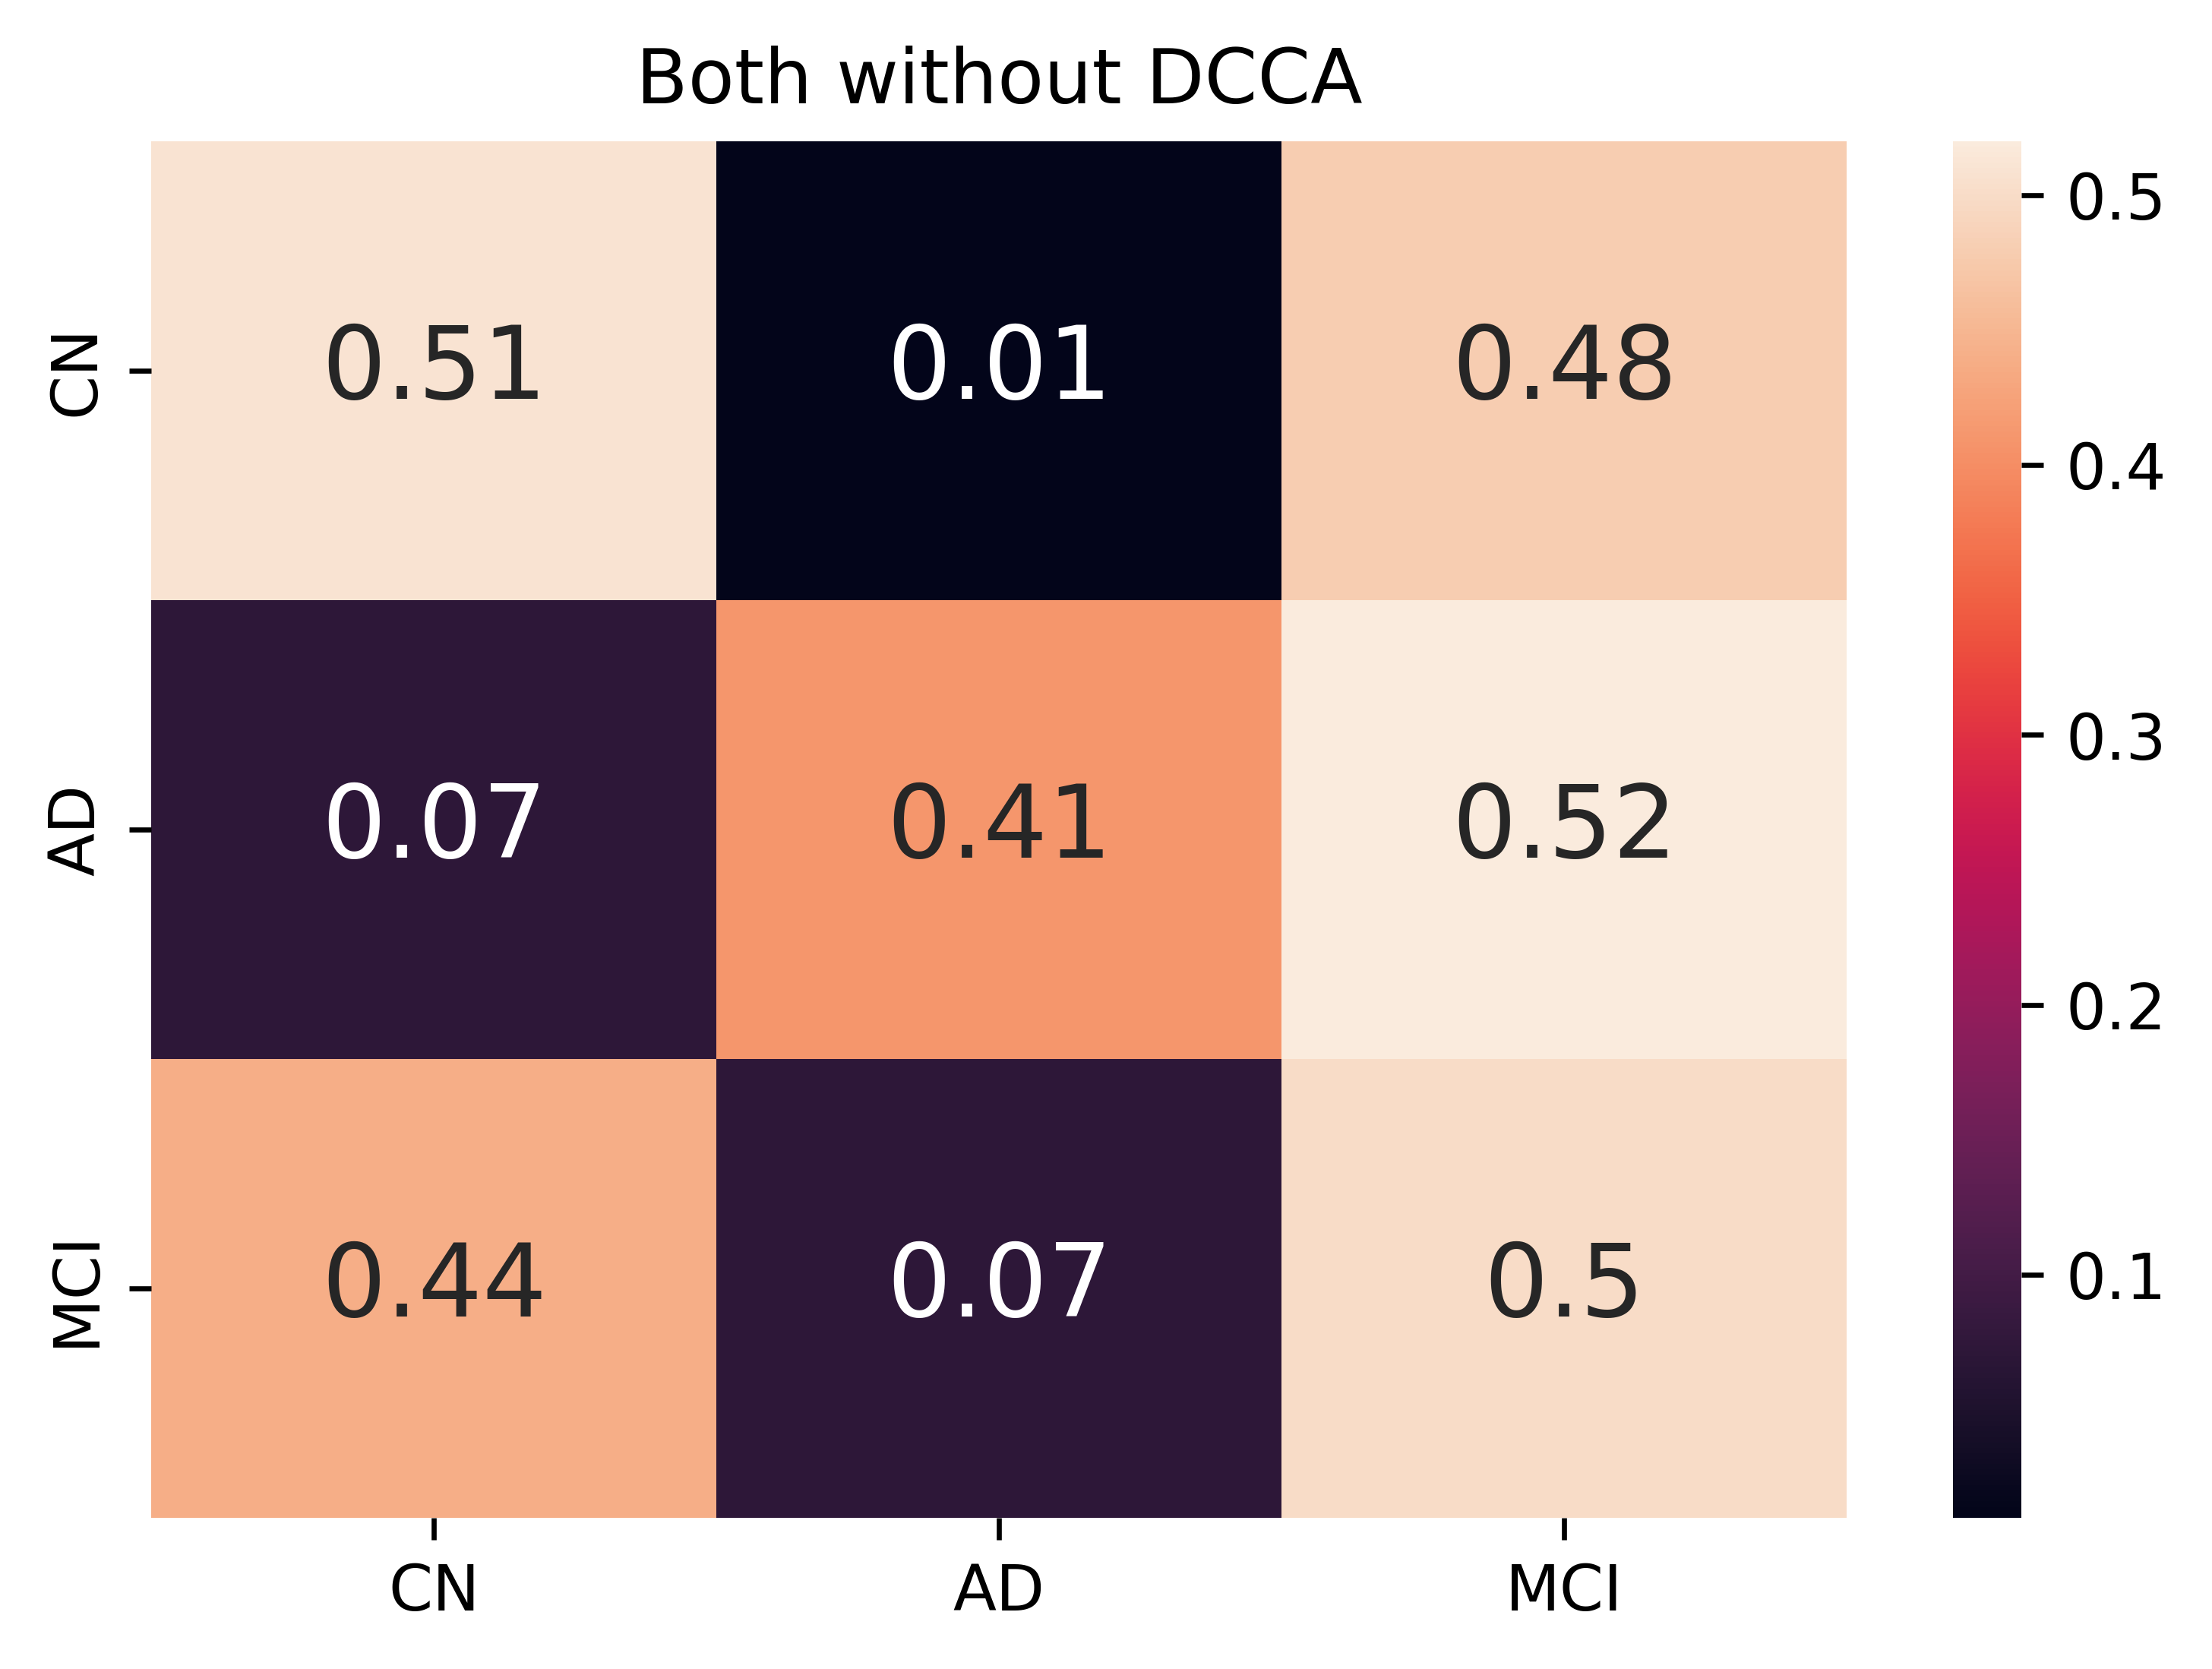

In [20]:
fig = plt.figure(dpi=600)
sns.heatmap(Confusion_Matrices[0], annot=True, annot_kws={"size": 16}, fmt='g',
                   xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title(names[0])
plt.show()